In [1]:
# Importing Numpy and Pandas library

import numpy as np
import pandas as pd

# Importing seaborn and matplotlib library for Data Visualisation

import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Specify the path to your JSON file
json_file_path = 'D:/Python/Retail Sales/retail_sale.json'

# Load the JSON file into a DataFrame
sale_1 = pd.read_json(json_file_path)

sale_1.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Country,Recency,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Complain,TotalAcceptedCampaigns,TotalMntSpent,Customer_Type,Responded,Age
0,1826,1970,Graduation,Divorced,84835.0,0,0,1402876800000,SP,0,...,0,0,0,1,0,0,967.5,Recent,False,54
1,1,1961,Graduation,Single,57091.0,0,0,1402790400000,CA,0,...,0,0,0,1,0,1,577.0,Recent,True,63
2,10476,1958,Graduation,Married,67267.0,0,1,1399939200000,US,0,...,0,0,0,0,0,0,251.0,Recent,False,66
3,1386,1967,Graduation,Together,32474.0,1,1,1399766400000,AUS,0,...,0,0,0,0,0,0,11.0,Recent,False,57
4,5371,1989,Graduation,Single,21474.0,1,0,1396915200000,SP,0,...,1,0,0,1,0,1,91.0,Recent,True,35


In [3]:
sale_model = sale_1[['Age', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Country', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Responded']].copy()
sale_model.head()

,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Country,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Responded
0,54,Graduation,Divorced,84835.0,0,0,SP,0,189,81,379,111.0,81,126.5,False
1,63,Graduation,Single,57091.0,0,0,CA,0,464,5,64,7.0,0,37.0,True
2,66,Graduation,Married,67267.0,0,1,US,0,134,11,59,15.0,2,30.0,False
3,57,Graduation,Together,32474.0,1,1,AUS,0,10,0,1,0.0,0,0.0,False
4,35,Graduation,Single,21474.0,1,0,SP,0,6,16,24,11.0,0,34.0,True


**Checking for Imbalance**

False    1777
True      463
Name: Responded, dtype: int64


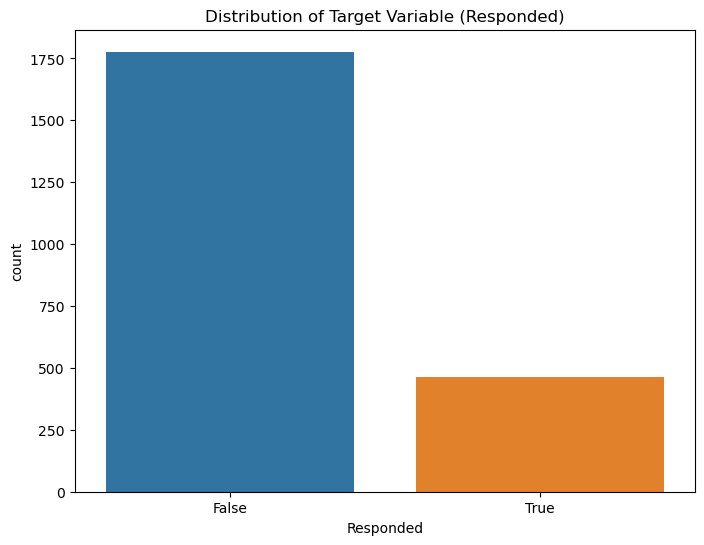

In [4]:
# Checking the distribution of the target variable
response_counts = sale_model['Responded'].value_counts()
print(response_counts)

# Visualizing the distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=sale_model, x='Responded')
plt.title('Distribution of Target Variable (Responded)')
plt.show()

**Resampling & Model Training with Balanced Data**

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encoding categorical variables
for column in sale_model.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    sale_model[column] = le.fit_transform(sale_model[column])

# Ensuring numerical columns are of numeric types
numerical_columns = ['Age', 'Income', 'Kidhome', 'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Recency']
sale_model[numerical_columns] = sale_model[numerical_columns].apply(pd.to_numeric, errors='coerce')

# Filling any NaN values that might have been introduced by coercing
sale_model.fillna(sale_model.median(), inplace=True)

# Separating features and target
X = sale_model.drop(columns=['Responded'])
y = sale_model['Responded']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Defining resampling strategy
oversample = SMOTE()
undersample = RandomUnderSampler()

# Creating pipeline
steps = [('o', oversample), ('u', undersample)]
pipeline = Pipeline(steps=steps)

# Applying resampling
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_scaled, y_train)

# Checking the new distribution of the target variable
print(y_train_resampled.value_counts())

False    1237
True     1237
Name: Responded, dtype: int64


In [10]:
# Training and evaluating models

model = RandomForestClassifier()
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]
results_resampled[name] = {
    'Classification Report': classification_report(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba)
}

# Displaying results and selecting the best model based on ROC AUC
print(results_resampled[best_model_name]['Classification Report'])
print(f"ROC AUC: {results_resampled[best_model_name]['ROC AUC']}")

              precision    recall  f1-score   support

       False       0.91      0.91      0.91       540
        True       0.61      0.61      0.61       132

    accuracy                           0.85       672
   macro avg       0.76      0.76      0.76       672
weighted avg       0.85      0.85      0.85       672

ROC AUC: 0.8477202581369248


**Model Performance:**
-  Based on the ROC AUC score, Random Forest is the best model with a score of **0.85**. It also has a balanced accuracy and better performance metrics compared to other models.

**Regularization and Hyperparameter Tuning**

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initializing the model
rf_model = RandomForestClassifier(random_state=42)

# Initializing GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)

# Fitting GridSearchCV to find the best hyperparameters
grid_search.fit(X_train_resampled, y_train_resampled)

# Getting the best model
best_rf_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_rf_model.predict(X_test_scaled)
y_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
classification_report_resampled = classification_report(y_test, y_pred, zero_division=0)
roc_auc_resampled = roc_auc_score(y_test, y_proba)

# Display the results
print("Best Hyperparameters:", grid_search.best_params_)
print("Classification Report:\n", classification_report_resampled)
print(f"ROC AUC: {roc_auc_resampled}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.91      0.90       540
        True       0.61      0.58      0.59       132

    accuracy                           0.84       672
   macro avg       0.75      0.74      0.75       672
weighted avg       0.84      0.84      0.84       672

ROC AUC: 0.8553591470258136


**Cross-Validation**

In [12]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_rf_model, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.96977439 0.97764301 0.98540551 0.9696193  0.97462669]
Mean CV Score: 0.9754137808329707


**Model Interpretation**
-  Feature Importance

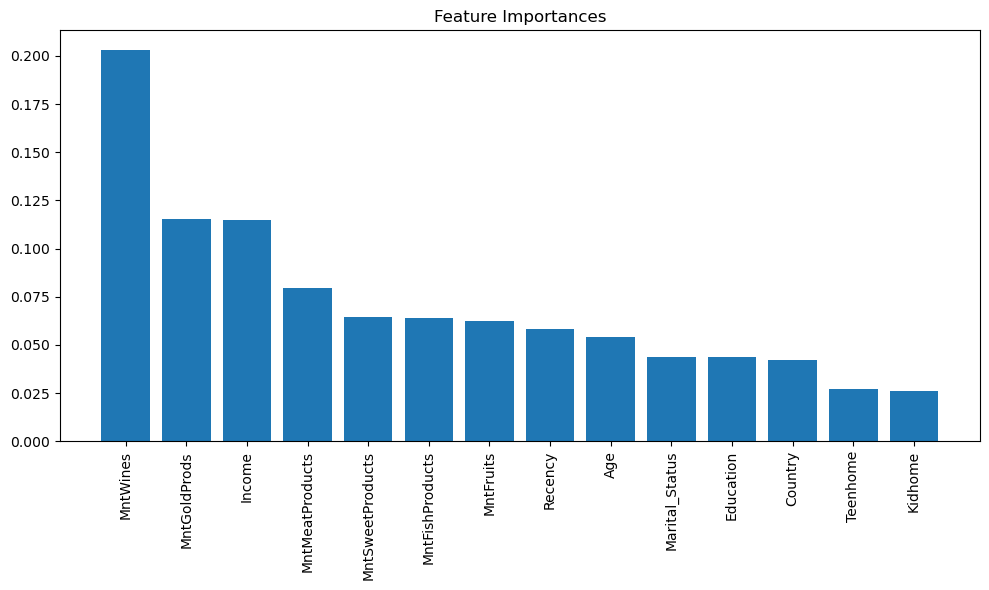

In [13]:
import matplotlib.pyplot as plt

# Get feature importances from the best model
feature_importances = best_rf_model.feature_importances_

# Plot feature importances
features = X.columns
importances = feature_importances
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()

**SHAP Values**

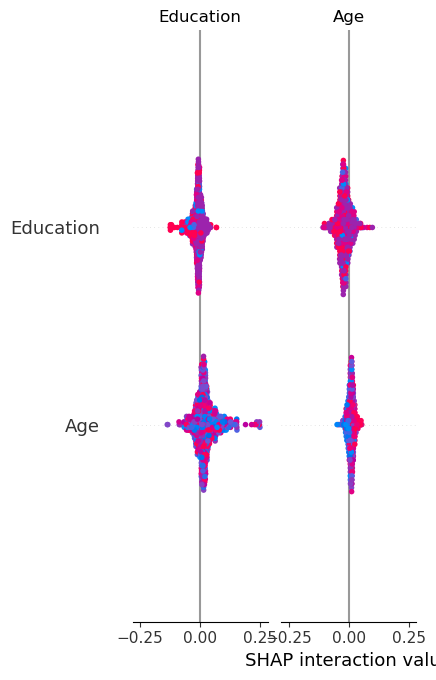

In [15]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

**Model Deployment**
- Saving the Model

In [17]:
import joblib

file_path = 'D:/Python/Retail Sales/retail_sale_model.pkl'

# Save the model to a file
joblib.dump(best_rf_model, file_path)

['D:/Python/Retail Sales/retail_sale_model.pkl']

In [24]:
import pickle

filename = 'D:/Python/Retail Sales/retail_sale_model.sav'
pickle.dump(best_rf_model, open(filename, 'wb'))

In [20]:
X_test.head()

,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Country,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
324,39,0,3,36145.0,1,0,7,13,56,4,76,17.0,1,18.0
96,62,3,3,58646.0,0,1,2,3,62,1,44,6.0,5,22.0
2104,38,2,3,71952.0,1,0,0,93,656,80,455,52.0,81,93.0
1259,68,2,4,46998.0,0,1,6,55,172,41,86,45.0,6,27.0
1061,58,1,5,22634.0,0,0,0,47,2,23,11,8.0,6,46.0


In [21]:
load_model = pickle.load(open(filename, 'rb'))

In [23]:
load_model.predict([[39, 0, 3, 36145.0, 1, 0, 7, 13, 56, 4, 76, 17.0, 1, 18.0]])

array([ True])